# Assignment 1

submitted by :
Tair Hakman & Yaniv Bin 

## Part 1 

### part 1.1

First We'd like to start with importing all the modules we're going to use in this notebook:

In [3]:
import nltk
import os
import re, pprint, collections
from urllib import request
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
import numpy as np
from os.path import abspath, dirname, join
import inspect
import matplotlib.pyplot as plt
import matplotlib
import math, statistics
from math import log
import random
from collections import *
import zipfile, tarfile
import string

We use the following code in order to tokenize the data based on the ptb method:

In [4]:
def replace_numbers(tokens):
    return [x if not x.isdigit() else 'N' for x in tokens]

def find_most_common(tokens, top):
    counter = collections.Counter(tokens)
    most_common = counter.most_common(top)
    return [a for a, b in most_common]

def replace_noncommon_tokens(sentences, most_common):
    res = []
    for sentence in sentences:
        res.append([x if (x in most_common) else '<unk>' for x in sentence])
    return res

def ptb_preprocess(filenames, top=10000):
    for single_file in filenames:
        path = nltk.data.find(single_file)
        raw = open(path, 'r').read()
        segments = raw.split("\n")
        sentences = []
        for segment in segments:
            tokens = word_tokenize(segment)
            # remove punctuation
            tokens = [x for x in tokens if x not in string.punctuation]
            # to lowercase
            words = [w.lower() for w in tokens]
            # filter numbers
            sentence = replace_numbers(words)            
            sentences.append(sentence)
       
        # get most common words and replace all other words with unk
        common_tokens = find_most_common([word for sentence in sentences for word in sentence], top)
        sentences = replace_noncommon_tokens(sentences, common_tokens)
        
        # write out the new data into a file 
        new_filename = single_file + ".out"
        with open(new_filename, 'w') as f:
            for sentence in sentences:
                for word in sentence:
                    f.write("%s " % word)
                f.write("\n")

We want to test the above code on a few example files:

In [3]:
path_to_first_file = abspath(join(dirname("__file__"), "segmentationExample.txt"))
path_to_second_file = abspath(join(dirname("__file__"), "SplitAndPuncExample.txt"))
path_to_third_file = abspath(join(dirname("__file__"), "numbersExample.txt"))
path_to_file_four = abspath(join(dirname("__file__"), "uncommonExample.txt"))

ptb_preprocess([path_to_first_file, path_to_second_file, path_to_third_file], 10000)

For example the file "segmentationExample.text" which contains the following lines:

In [4]:
with open(path_to_first_file) as f:
    print(f.read())

We expect this file
to be with the same lines
as shown here
so let's hope it does


Will result in the file "segmentationExample.text.out":

In [5]:
path_to_first_result = abspath(join(dirname("__file__"), "segmentationExample.txt.out"))
with open(path_to_first_result) as f:
    print(f.read())

we expect this file 
to be with the same lines 
as shown here 
so let 's hope it does 



The file "SplitAndPuncExample.txt" :

In [6]:
with open(path_to_second_file) as f:
    print(f.read())

we want to make sure this text reader splits words like don't the right way,
and also that it will remove all the punctioation marks, because we don't need those in our life :
here, they're gone. 


Will result in the files "SplitAndPuncExample.txt.out"

In [7]:
path_to_second_result = abspath(join(dirname("__file__"), "SplitAndPuncExample.txt.out"))
with open(path_to_second_result) as f:
    print(f.read())

we want to make sure this text reader splits words like do n't the right way 
and also that it will remove all the punctioation marks because we do n't need those in our life 
here they 're gone 



The file "numbersExample.txt":

In [8]:
with open(path_to_third_file) as f:
    print(f.read())

see how 123 will turn into the number format
even if it's 123$
or #123 or 1 2 3 
a number is always a number


Will result in the files "numbersExample.txt.out":

In [9]:
path_to_third_result = abspath(join(dirname("__file__"), "numbersExample.txt.out"))
with open(path_to_third_result) as f:
    print(f.read())

see how N will turn into the number format 
even if it 's N 
or N or N N N 
a number is always a number 



to show uncommon words filtering we will reduce the size of filtering (indtead of a 10000) to 10:

In [10]:
ptb_preprocess([path_to_file_four], 10)

if we test it with the file "uncommonExample.txt":

In [11]:
with open(path_to_file_four) as f:
    print(f.read())

we have over ten words in this file, 
but the word file and the word word are more frequent for example...


we get:

In [12]:
path_to_file_four_result = abspath(join(dirname("__file__"), "uncommonExample.txt.out"))
with open(path_to_file_four_result) as f:
    print(f.read())

we have over ten words in this file 
<unk> the word file <unk> the word word <unk> <unk> <unk> <unk> <unk> <unk> 



the results for running our tokenizer on shakespears work:

In [ ]:
path_to_shakespear = abspath(join(dirname("__file__"), "shakespear.txt"))
ptb_preprocess([path_to_shakespear], 10000)

can be found under a file called "shakespear.txt.out" attached to the assignment

#### part 1.1.2 

Now we'll be using the code of the previous part on the PTB dataset:

In [14]:
ptb_train_path = abspath(join(dirname("__file__"), "ptb.train.txt"))
ptb_test_path = abspath(join(dirname("__file__"), "ptb.test.txt"))
with open(ptb_train_path) as f:
    ptb_train = f.read()
with open(ptb_test_path) as f:
    ptb_test = f.read()

Now it's time to report some basic statistics on the training data:

Number of tokens: 978726
Number of characters: 5108686
Number of distinct tokens: 9996
Total number of tokens corresponding to the top-N most frequent words in the vocabulary: 785187
Type distribution: 
unk:  0.045998573655956825
numbers:  0.033187020677901684
rest:  0.9208144056661415
Average number and standard deviation of characters per token: 4.2197315694075765 2.705652415851888
Distinct n-grams of words of length 2 : 277419
Distinct n-grams of words of length 3 : 598666
Distinct n-grams of words of length 4 : 754993
Distinct n-grams of characters of length 2 : 763
Distinct n-grams of characters of length 3 : 6246
Distinct n-grams of characters of length 4 : 29334
Distinct n-grams of characters of length 5 : 105574
Distinct n-grams of characters of length 6 : 291396
Distinct n-grams of characters of length 7 : 600865


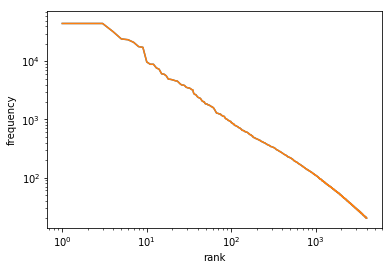

In [16]:
def gather_stats (text, n):
    tokens = word_tokenize(text)
    text = " ".join(tokens)
    corpus_counts = nltk.FreqDist(tokens)
    common = find_most_common (tokens, n)
    words_len = [len(x) for x in tokens]
    print("Number of tokens:", len(tokens))
    print("Number of characters:", len(text))
    print("Number of distinct tokens:", len(corpus_counts))
    print("Total number of tokens corresponding to the top-N most frequent words in the vocabulary:",
           len([x for x in tokens if x in common]))
    
    print("Type distribution: ")
    unk_count, num_count = corpus_counts.get("unk"), corpus_counts.get("N")
    print("unk: ", unk_count / len(tokens))
    print("numbers: ", num_count / len(tokens))
    print("rest: ", (len(tokens) - unk_count - num_count) / len(tokens))

    print("Average number and standard deviation of characters per token:", 
           statistics.mean(words_len), statistics.stdev(words_len))
    
    wordGrams=[]
    for i in range (2,5):
        ng = generate_ngrams (tokens, i)
        gramCount = nltk.FreqDist(ng)
        print ("Distinct n-grams of words of length", i, ":", len(gramCount))
        wordGrams.append([i, len(gramCount)])    
    
    chars = [c for c in text]
    for i in range (2,8):
        ng = generate_ngrams (chars, i)
        gramCount = nltk.FreqDist(ng)
        print ("Distinct n-grams of characters of length", i, ":", len(gramCount))
        
    plt.loglog([val for word,val in corpus_counts.most_common(4000)])
    plt.xlabel('rank')
    plt.ylabel('frequency')
    plt.show()
    
def generate_ngrams (tokens, n):
    g = ngrams(tokens, n)
    return [x for x in g]

gather_stats(ptb_train, 1000)

The graph confirms our assumption, that word count distributions in the PTB dataset indeed do follow power law distributions.

## part 1.2

the following is an implementation of the ngram model:

In [17]:
class NgramModel(object):
    def __init__(self, n, train, smoothing=False, estimator=None):
        self._n = n
        self.is_unigram_model = (n == 1)
        self.is_smooth = smoothing
        
        cfd = nltk.ConditionalFreqDist((" ".join(train[i : i + n - 1]), "".join(train[i + n - 1])) for i in range(len(train) - n + 1))
        self._probdist = nltk.ConditionalProbDist(cfd, estimator)
        
        # if we are not using smoothing we should implement a backoff model and keep all the seen ngrams
        if not self.is_smooth:
            self._ngramsData = ngrams(train, n)
            self._ngrams = set()
            for ngram in self._ngramsData:
                self._ngrams.add(ngram)
        
        if not self.is_unigram_model:
            if not self.is_smooth:
                self._backoff = NgramModel(n - 1, train, estimator=estimator)
                self._lambda = 1
    
    def prob(self, word, context):
        if (self.is_smooth and self._probdist[context].logprob(word) != 0):
            return self._probdist[context].logprob(word)
        
        # if we are not using smoothing we need to use a different method for avoiding 0 probability 
        elif (tuple(context.split()) + (word, ) in self._ngrams) or (self.is_unigram_model):
            return self._probdist[context].logprob(word)
        else:
            new_context = " ".join(context.split()[1:])
            backoff = self._backoff.prob(word, new_context)
            return self._lambda * backoff
        
    def logprob(self, word, context):
        return - self.prob(word, context)
    
    def get_seed(self):
        return random.choice(self._probdist.conditions())
    
    def generate(self, seed, length):
        out = []
        curr = seed
        end = self._probdist.conditions()[-1]
        i = 0
        while (i <= length and (not curr == end)):
            i += 1
            word = self._probdist[curr].generate()
            curr = " ".join((curr.split())[1:] + [word])
            out.append(word)
        return out

In [18]:
def train_word_lm(dataset, n=2):
    model = NgramModel(n, dataset, estimator=nltk.MLEProbDist)
    return model

The data structure required to build the model is - a dictionary of size at most the number of N-grams multiplied by the size of the vocabulary - so we get:

In [19]:
%%latex
\begin{align}
{\mathbf{dictSize}} & = \frac{{\mathbf{Vocabulary}}}{N} * \mathbf{Vocabulary}
\end{align}

<IPython.core.display.Latex object>

Aside from that we also save an array of all possible ngrams, and the backoff in case we don't use a smoothing technique.
To save the backoff - that is in order to use the backoff technique over the perplexity calculations - the data structure is similar and defined recursively.
One can also note we did not implement a smoothing as a Katz backoff using alpha - but a more accturate results would have been preduced if we did so. 

As we can see in the given class implementation - the model should export methods for evaluating itself, for generating random text, and for calculating the probabilty and entropy of a word given a context. 

the memory required for holding the model(non smoothing) is therefore at most: 

In [20]:
%%latex
\begin{align}
{\mathbf{dictSize_N}} & = \frac{{\mathbf{Vocabulary}}}{N} * \mathbf{Vocabulary} \\
{\mathbf{Memory}} & = {\mathbf{dictSize_N}} + {\mathbf{dictSize_(N + 1)}} + \dots + {\mathbf{dictSize_1}} + {\mathbf(size-of-ngrams)}
\end{align}

<IPython.core.display.Latex object>

for a smoothing using model - we don't need to save anything other than the initial ngram dictionary (no need to build it using recursion or keeping all seen ngrams), in that case it takes a much smaller memory of at most: 

In [21]:
%%latex
\begin{align}
{\mathbf{dictSize_N}} & = \frac{{\mathbf{Vocabulary}}}{N} * \mathbf{Vocabulary} \\
\end{align}

<IPython.core.display.Latex object>

## part 1.3

We'd like to measure how well our model is doing, we can do so by using a measure called perplexity - a model perplexity can be evaluated as followed:

In [22]:
def model_entropy(model, text, n=2):
    H = 0.0
    for i in range(n - 1, len(text)):
        context, word = tuple(text[i - n + 1:i]), text[i]
        context = " ".join(context)
        H += model.logprob(word, context)
    return H / float(len(text) - (n - 1))

def calc_preplexity(model, text, n=2):
    text_entropy = model_entropy(model, text, n)
    return 2 ** (text_entropy)

The lower the perplexity - the better the model.

When testing the above implemented model on the ptb training and validation data we get:

In [23]:
ptb_train_tokenized = ptb_train.split()
ptb_test_tokenized = ptb_test.split()

In [24]:
# Train the ngram model with n = 3
n = 3
lm_MLE = train_word_lm(ptb_train_tokenized, n)

print(calc_preplexity(lm_MLE, ptb_test_tokenized, n))

107.32412922857847


As mentioned, we can always use a different estimator in order to change our model perplexity, for example, the following model is using the Lidstone estimator with a gamma instead of the MLE one:

In [25]:
def train_word_lm_lidstone(dataset, n=2, gamma=0.01):
    lidstone_estimator = lambda fd: nltk.LidstoneProbDist(fd, gamma, fd.B() + 100)
    model = NgramModel(n, dataset, smoothing=True, estimator=lidstone_estimator)
    return model

In this case we don't need to use the backoff technique because the lidstone estimator provides a smoothing over the probabilities - instead of using regular MLE it's like creating "bins" and the depositing an initial amount into each bin, and then add to that all the actual probabilities. By doing so we will never reach a point where the probability is 0 (unless gamma is 0).
The formula it uses to do so is described as (for an experiment with count c, B bins and N outcomes) - 

In [26]:
%%latex
\begin{align}
\frac{{\mathbf{c + gamma}}}{\mathbf{N + B * gamma}} \\
\end{align}

<IPython.core.display.Latex object>

Notice how selecting the size of B can change the probability - We chose this value after some trial and error with the values, intending to not create a too sparse result. 

We get the following perplexity:

In [27]:
n = 3
gamma = 0.01
lm_LIDSTONE = train_word_lm_lidstone(ptb_train_tokenized, n, gamma)
print(calc_preplexity(lm_LIDSTONE, ptb_test_tokenized, n))

131.03836275826552


The following graph shows how differnt gamma values in such model change the results of the function:

In [28]:
gammas = np.linspace(0.01, 1, 20)
n = 3
perplexities_l = list(range(20))
i = 0
for gamma in gammas:
    lm_LIDSTONE = train_word_lm_lidstone(ptb_train_tokenized, n, gamma)
    perplexities_l[i] = calc_preplexity(lm_LIDSTONE, ptb_test_tokenized, n)
    i += 1

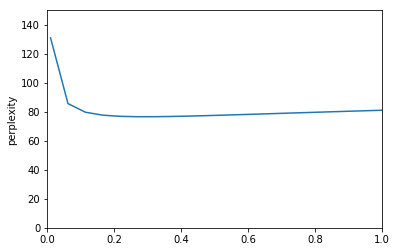

In [29]:
plt.plot(gammas, perplexities_l)
plt.axis([0, 1, 0, 150])
plt.ylabel("perplexity")
plt.show()

another way is to change the value of the n-grams , and that results in different perplexity - an example of the difference can be seen in the following graph:

In [30]:
perplexities_m = list(range(2, 20))
gamma = 0.01

for n in range(2, 20):
    lm_LIDSTONE = train_word_lm_lidstone(ptb_train_tokenized, n, gamma)    
    perp = calc_preplexity(lm_LIDSTONE, ptb_test_tokenized, n)
    perplexities_m[n - 2] = perp

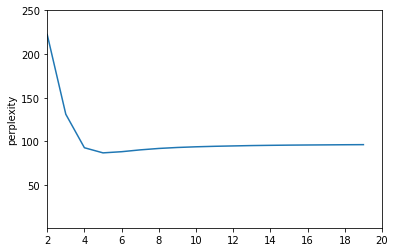

In [31]:
n_vals = list(range(2, 20))

plt.plot(n_vals, perplexities_m)
plt.axis([2, 20, 1, 250])
plt.ylabel("perplexity")
plt.show()

One can see starting with a low value of n we get really high perplexity(bad) and as we increase the value the perplexity gets better, that is until it reaches 7, that is because the ngrams are getting too large so most of them become unseen ngrams (a 7 words sentence is too long to be frequently repeated in the text) So the ideal size for n is at about n=6. 

based on the two models above and the two graphs, we can now compose the "ideal" model:

In [32]:
n = 6
gamma = 0.2
lm_IDEAL = train_word_lm_lidstone(ptb_train_tokenized, n, gamma)
print(calc_preplexity(lm_IDEAL, ptb_test_tokenized, n))

89.92074266919535


The results we get are pretty bad compared to the best models there are out today - 
for example a Neural Sequence Model with Dynamic Evaluation suggested by *Ben Krause, Emmanuel Kahembwe, Iain Murray, & Steve Renals* (can be found in https://arxiv.org/pdf/1709.07432.pdf) gets a perplexity of 46.4 on the Penn Treebank.
<br> We do get decent results considering the fact we don't use any deep learning techniques. 

### part 1.3.2 

Another way of using the model is by generating text using it, the following method generates text given a model and a seed(a starting prefix):

In [33]:
def generate(model, seed):
    out = model.generate(seed, 100)
    out = seed + " " + " ".join(out)

    print(out)

One can note this method is not ideal if the seed length is smaller than the ngram size we used to train the model, a way to avoid such problem is to find a matching ngram starting with the seed and running the method from there ) or just making sure the seed is big enough. Another way is the issue of halting - here I gave it a number of iteration or forced it to halt when it sees the last possible ngram. 
Another issue that might arise is if the model run into an unknown history, in my case the code will break, so one must make sure no unknown history will occure - to do so we have the condition in the while loop, another way to avoid it is similar to the backoff we can also reduce the ngram size down and go back a step with the probability (selecting next word based on that). 
I made this generator limited to 100 iterations if possible because I didn't want to make it generate to big of a file given a large model, but one can easily change that number to anything. 

Here are a few different examples of using the previously trained model with different seeds:

In [34]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: coupon rate on the issue
coupon rate on the issue when it is reset is N N debenture holders also will receive the equivalent of N N of the concern in a securities and exchange commission filing norwood said it 's part of a group that holds N N of its stock in friendly hands manville is the rare publicly traded company that can ignore short-term stock fluctuations and plan for the long haul manville nyse symbol <unk> business forest products and <unk> year ended dec. N N revenue $ N million net loss $ N million N cents a share third quarter sept. N N per-share earnings N cents vs.


In [35]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: robert redford the <unk> kid
robert redford the <unk> kid gets little respect around <unk> <unk> conversations with us mr. <unk> argued that mr. redford 's environmental views are at odds with utah residents this may have been true N years ago but times have changed even in utah mr. redford no longer stands out as an <unk> he has not changed but those around him have many of his views on the protection of <unk> areas <unk> and <unk> are now embraced by mainstream conservative <unk> recently some N environmental and <unk> groups representing such <unk> points of view as the sierra club the league of women voters and the


In [36]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: more on <unk> advertising and
more on <unk> advertising and promotion in the second half of N usair stock could hit N says <unk> <unk> of shearson lehman hutton says if you <unk> your income to another you still have controlled its <unk> and enjoyed the <unk> of your labor even if indirectly ben earns any fees sent directly to charity and is taxable on them the irs says of course he also may take a charitable deduction for them briefs ways and means veteran <unk> d. <unk> moves to the house budget committee rep. <unk> d. md <unk> him seattle 's license fees for adult <unk> shows vary from those


In [37]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: when there are few that
when there are few that tends to tilt the public debate toward solutions even when some of the most knowledgeable scientists are skeptical about the <unk> of the separate documents <unk> to the new york times the papers which israel says were discovered in <unk> <unk> refer to terrorist acts to be carried out in the name of a group called the revolutionary <unk> some supporters of israel say u.s. policy on palestinian terrorism is <unk> by an intense desire to maintain the dialogue with the plo but state department officials accuse israel of <unk> questionable claims to <unk> the u.s. the dollar finished lower yesterday


In [38]:
seed = lm_IDEAL.get_seed()
print("SEED:", seed)
generate(lm_IDEAL, seed)

SEED: intelogic affiliate the action followed
intelogic affiliate the action followed by one day an intelogic announcement that it will retain an investment banker to explore alternatives to maximize shareholder value including the possible sale of the financially struggling company <unk> <unk> mass. makes digital electronic <unk> instruments used by professional recording musicians it recently introduced a line for the home market however raymond c. <unk> chairman and chief executive officer noted that the new repurchase program should serve to enhance shareholder value a spokeswoman said the company will finance the buy-back with cash on hand borrowing and cash norfolk expects to generate analysts said they expected the action and investors <unk>


As mentioned, this is a deterministic method that will always result in the same (or very similar in case of an equal probabilty) results. In order to create a more random generator the Temprature parameter was introduced to the generator. 

Temperature sampling uses a parameter t to determine how “strong” the change will be. We use the parameter to calculate a new probability to every option,it will generally be a number between 0 and  1, and once we set it we sample with it. 
the new probability will then be defined by :
<br>$\tilde{p_i} = f_{\mathcal{T}}(p)_i =  \frac{p_i ^ {\frac{1}{\mathcal{T}}}}{\sum_{j}p_i}$

We can now examine this - we note that for t = 1, the probability stays identical. For t = 0.5 we are squaring the probabilities and renormalizing.
Let's take an example of two probabilities, p1=0.6, p2=0.4, and see how this formula affects them for t=0.5 and t=0.1:


$\tilde{p_1}_{(\mathcal{T}=0.5)} =  \frac{0.36}{0.52} \sim 0.69 $
<br>$\tilde{p_2}_{(\mathcal{T}=0.5)} =  \frac{0.16}{0.52} \sim 0.30 $
<br>$\tilde{p_1}_{(\mathcal{T}=0.1)} \sim 0.98 $
<br>$\tilde{p_2}_{(\mathcal{T}=0.1)} \sim 0.02$

In this example, we can observe how the change in t affect the result. A lower t value gives the "stronger" values an even higher probability, and when t approaches 0 the strongest option is becoming certain, effectively going back to deterministic input.
We can use the temperature parameter to express how much we ‘trust’ the model, and to add controlled amounts of randomness to our generations.

Now lets take a look at the code by Sameer Sing. He chose to work with log probabilities in order to achieve the same results.
The first part of his code does two things:
- Create a list called ‘wps’. Each element in his list is a pair of a word w, and the log probability of w divided by temp $\frac{\log (p(w))}{t}$.
- Sums the total of the $\frac{\log (p(w))}{t}$ values, so he can use it as a normalizing factor. By the time the loop finishes, tot is equal to:

tot = $\log_2(2^{\frac{\log (p(w_1)}{t}} + 2^{\frac{\log (p(w_2)}{t}}+ \dots + 2^{\frac{\log (p(w_n))}{t}})$

Now after he assigned weighted log probabilities, it’s time to choose a random word based on the new probability. This is how it's done:

At first a random number p $(0<p<1)$ is chosen. Now for every possible word, he perform the following steps:
- Sum the logs probabilities so far $s$.
- Subtract $s$ from the total we counted in the first part, and calculate $2^{ourResult}$.
- if $p$ is smaller than the answer, the word is chosen.

To understand why it works, lets continue with our example:

$p_1 = -1.473$ . This is the only log we’ve encountered yet, so $s = p_1$.
<br>$2^{s-tot} = 0.69$ 

One can note this is the __exact same probability we calculated in the first part.__
How did this happen?
- In the first part we computed $p^{\frac{1}{t}}$
- In the second part we computer $2^{\log \frac{p}{t}}$
<br>But those expressions are equivalent :
$2^{\frac{\log_2{p}}{t}} = 2^{\log_2{p} * \frac{1}{t}} = p^{\frac{1}{t}}$

The same applies to the normalizing sum below. And obviously, our random number p has a probability of 0.69 to be smaller than 0.69, hence giving the same word an 0.69 chance to be chosen.
So as we see, the code by Sameer Sing effectively uses the exact same mathematical idea of temperature expressed by Russel Stewart, but implemented using logs.


## part 1.4

We were asked to read and summarize two articles about RNNs. 
The first article, by Andrej Karpathy, provides a general introduction and description of RNNs. Here is the summary:

"Unlike normal Neural Networks, Recurrent Neural Networks (RNNs) allow us to operate over __sequences of vectors.__, and not just one. Considering it is still a Neural Network, it operates similarly to any other - it has a “step” function that gets an input vector x and returns an output vector y. But RNN's have one major difference – they keep a hidden vector h, whose value are updated in every computation and are used to generate the output. So the output depends not only on the current input vector, but also on the entire history of vectors it ever computed.

More precisely, the RNN keeps three matrices: W_xh (input to hidden),  W_hh (hidden to hidden), W_hy (hidden to output). We first initialized them to random matrices and every time “step” is called, we use them to update h and calculate the output.

When constructing a language char-based model using RNN, Karpathy gets pretty good results (even for surprising things like Linux source code). In order to better understand the process, Karpathy samples it in different stages to see how it “learns”. In the first iterations it composes gibberish, by the 700 iteration it learns words, and by 2000 it can write full complex sentences. Karpathy also visualize values in neurons, and observe how certain neurons are used for certain tasks, even though it wasn’t coded by humans – the network ‘decided’ upon it.

RNN’s are a growing field that is widely used for models of NLP, Computer Vision and other fields.
They still have flaws (like being good at memorizing but not always in generalization, or using a very large computations in each step), but there is a lot of progress and they are evolving daily". 

The second article, by Yoav Goldberg, discusses using char-based language models for the same task, and discusses the differences between the results.

"Replying to the previous article, Goldberg points out that text generation can also be achieved in a much simpler method: Unsmoothed Maximum Likelihood Character Level Language Model. This is a simple model that “learns” by reading texts. It has a fixed parameter n called “order”, and for every string of n characters the model encounters, it keeps a count of what the next character was. Hence, for a combination of n chars (ngram), the model can give us a distribution of the probability of the next char, and answer about the likelihood of a specific char to be next. If the model never saw a character after a given ngram, the probability will be 0.

After training the model on Shakespeare texts, we now test it in text generation. Lower orders are gibberish, but the higher the order is, the results are getting better and are looking more like convincing Shakespeare text. However, this model has limitations – it isn't aware of context, or anything beyond the last n characters. For example, when generating Linux code, the RNN model is able to generate code that is well indented, with correctly nested brackets. The language model isn’t capable of doing that, even when choosing high orders. Of course, it’s possible to update the model to support it; but what’s so impressive about RNN is, it learned to do it on it’s own, without being specifically coded to do so".

So now, it's time to start working on the recipe databse. We'll be using Yoav Goldberg's model, adapted to Python3 and NLTK, with Lindstone estimator in order to avoid zero probabilites:

In [5]:
def create_lm_Lidstone(data, order=4, gamma = 0.01):
    pad = '*' * order
    data = pad + data
    cfd = nltk.ConditionalFreqDist((data[i : i + order], data[i + order]) for i in range(len(data) - order))
    cpd = nltk.ConditionalProbDist(cfd, nltk.LidstoneProbDist, gamma, bins=1000)
    return cpd

We would like to use new model and train it on the cooking recipes.
First we need to gather the data:

In [11]:
!wget http://www.ffts.com/recipes/lg/lg32965.zip

with zipfile.ZipFile("lg32965.zip","r") as zip_ref:
    zip_ref.extractall("recipes")

file_list = os.listdir("recipes")
enc = 'iso-8859-15'
recipes = ""
for file in file_list:
    recipes_from_file = open("recipes/" + file, 'r', encoding=enc).read()
    recipes_from_file.translate(string.punctuation)
    recipes += recipes_from_file

--2018-11-27 23:52:00--  http://www.ffts.com/recipes/lg/lg32965.zip
Resolving www.ffts.com (www.ffts.com)... 66.96.149.1
Connecting to www.ffts.com (www.ffts.com)|66.96.149.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11805248 (11M) [application/zip]
Saving to: ‘lg32965.zip’

lg32965.zip         100%[===================>]  11.26M  2.63MB/s    in 5.0s    

2018-11-27 23:52:06 (2.25 MB/s) - ‘lg32965.zip’ saved [11805248/11805248]



KeyboardInterrupt: 

We want to gather some statistics on them. We'll split the file to recipes using the string "MMMMM----- Recipe via Meal-Master (tm) v8.05", which seperates strings in the file.

In [ ]:
def get_stats(recipes):
    #(number of recipes, tokens, characters, vocabulary size, 
    #distribution of the size of recipes in words and in chars, distribution of length of words).
    recipes_list = recipes.split("MMMMM----- Recipe via Meal-Master (tm) v8.05")[1:]
    all_tokens = word_tokenize(recipes)
    print ("number of recipes:", len(recipes_list))
    print ("number of tokens:", len(all_tokens))
    print ("number of characters:", len (recipes))
    print ("size of vocabulary:", len (set(all_tokens)))
    print ("distribution of size of recipes in chars:")
    print_char_dist (recipes_list)
    print ("distribution of size of recipes in tokens:")
    print_words_dist (recipes_list)
    print ("distribution of length of words:")
    print_words_length (all_tokens)
    
def print_char_dist (recipes_list):
    recipes_chars_len = [len(i) for i in recipes_list]
    plt.hist(recipes_chars_len, bins=100)
    plt.xlabel ("Number of chars in recipe")
    plt.ylabel ("Amount")
    plt.show()
    
def print_words_dist (recipes_list):
    tokened_recipes = [word_tokenize(r) for r in recipes_list]
    recipes_words_len = [len(i) for i in tokened_recipes]
    plt.hist(recipes_words_len, bins=100)
    plt.xlabel ("Number of tokens in recipe")
    plt.ylabel ("Amount")
    plt.show()

def print_words_length (all_tokens):
    words_len = [len(i) for i in all_tokens]
    plt.hist(words_len, bins=100)
    plt.xlabel ("Word length")
    plt.ylabel ("Amount")
    plt.show()
    
get_stats(recipes)

Note: the one long word in the recipes dataset is a string of 70 "+" characters in a row, used as a delimiter in the text.

Our next step will be to split the dataset. The Python interface chosen is a dictionary with three keys: train, dev and test, so we can easily access every set.

In [7]:
def split_data (recipes):
    #returns a dictionary of train, dev, test
    eighty_per = round(len(recipes) * 0.8)
    ten_per = round(len(recipes) * 0.1)
    return {
        "train": recipes[:eighty_per], 
        "dev": recipes[eighty_per : eighty_per + ten_per],
        "test": recipes[eighty_per + ten_per:]
    }

sets = split_data(recipes)

Now let's train the model on our data. We'll try with order 4.

In [8]:
lm4 = create_lm_Lidstone(sets.get("train"), 4)

We need to modify our perplexity method from earlier to fit a character model:

In [9]:
def char_model_entropy(model, text, n=2):
    H = 0.0
    for i in range(n - 1, len(text)):
        context, char = text[i - n:i], text[i]
        H += model[context].logprob(char)
    return -(H / (len(text) - (n - 1)))

def calc_perplexity_char(model, text, n=2):
    text_entropy = char_model_entropy(model, text, n)
    return 2 ** (text_entropy)

And the perplexity of such model is:

In [10]:
calc_perplexity_char(lm4, sets.get("dev"), 4)

2.986077705910871

So we observe that the perplexity is very low. Let's try other orders:

In [ ]:
lm7 = create_lm_Lidstone(sets.get("train"), 7)
calc_perplexity_char(lm7, sets.get("dev"), 7)

In [ ]:
lm10 = create_lm_Lidstone(sets.get("train"), 10)
calc_perplexity_char(lm10, sets.get("dev"), 10)

So for order 7 the results are still low. For order 10, it gets a big higher, but still very low compared to the values we've witnessed at the previous part. How is it possible? Let's examine the probabilities (rather than the log probabilities) and calculate their average:

In [ ]:
def get_average_prob (model, text, n, isWordsModel):
    s = 0
    for i in range(n - 1, len(text)):
        context, char = text[i - n:i], text[i]
        if isWordsModel:
            context = " ".join(context)
        s += model[context].prob(char)
    return (s / (len(text) - (n - 1)))

In [ ]:
print("order 4:", get_average_prob(lm4, sets.get("dev"), 4, False))
print("order 7:", get_average_prob(lm7, sets.get("dev"), 7, False))

We see that in both cases, the average probability is very high. For comparison, in the example we've discussed in previous questions (based on ptb model), the average (after smoothing) was about 0.06. There are two possible reasons for it:

-The recipe database is a lot easier to predict. It is limited to one subject and one types of texts, all of whom are formatted similarly and using similar expressions. The text isn't diverse, so it's easier to predict.

-The use of a character-based model, rather than a words-based model, might cause lower perplexity - there are less options to predict each way.

So which of those observations are correct? Let's try and test the PTB dataset on a character model, and the recipes dataset on a word model.

In [ ]:
ptb_char = create_lm_Lidstone (ptb_train, 4)
print("ptb perplexity:", calc_perplexity_char(ptb_char, ptb_test, 4))
print("ptb average probability:", get_average_prob(ptb_char, ptb_test, 4, False))

In [ ]:
train_tokenized = word_tokenize(sets.get("train"))
dev_tokenized = word_tokenize(sets.get("dev"))
recipes_words_lm = train_word_lm_lidstone(train_tokenized, 5)
print("recipes word perplexity:", calc_preplexity(recipes_words_lm, dev_tokenized, 5))
print("recipes word average probability:", get_average_prob(recipes_words_lm._probdist, dev_tokenized, 4, True))

So our conclusion is: it seems that for the character model, the results for the ptb dataser are similar to the recipes database - a very low perplexity, and a very high average probability (0.5 is a bit lower than 0.57, perhaps because of the subject variety in ptb, but still relatively very high).

For the word model, we get a perplexity of 36 - which is much lower than the perplexities ftb had (around 100), but also much higher than the word models perplexities. The average probability is also between them - 0.2. It seems that the recipes dataset is indeed less varied (and hence easier to guess), but the deciding factor seems to be the type of model - character based models generally seem to have much lower perplexity.

Now we'll generate a few samples from those langauge models, and see how they turn out. We'll be using different orders to see which one brings the best results.

In [ ]:
def generate_letter(lm, history, order):
    history = history[-order:]
    return lm[history].generate()
     
def generate_text(lm, order, nletters=1000):
    history = "~" * order
    out = []
    for i in range(nletters):
        c = generate_letter(lm, history, order)
        history = history[-order:] + c
        out.append(c)
    return "".join(out)

In [ ]:
print(generate_text(lm4, 4, 1000))

In [ ]:
print(generate_text(lm7, 7, 1000))

In [ ]:
print(generate_text(lm7, 7, 1000))

In [ ]:
print(generate_text(lm10, 10, 1000))

In [ ]:
print(generate_text(lm10, 10, 1000))

A few observations about those generations:

- All models create mostly existing, and relevant words. Order 4 occasionally creates gibberish words (such as "DIPPERSON"), but this seems to become much rarer in orders 7 and 10.

- The recipe delimiter ("MMMMM...") appears frequently in generations. Sometimes the complete phrase (including "Recipe via...") appears too. In order 7, the delimiter seems to appear fairly randomly. However, in order 10, his positions makes sense: it appears after the end of a recipe (after "Posted by", "Courtesy of") and immediately followed by the beginning of a new recipe ("Title: ").

- Both order 10 and order 7 seems to keep some basic formatting. "Title:" will be followed by an uppercase recipe name, "Categories:" will be followed by a list of one or more categories, separated by commas, where every item begins with a cpital letter. "Yield:" is always followed by the number of servings.

- List of ingredients seems to somewhat stick together. The formatting remains: number, unit, and name of ingredient, and usually several of those lines appear in a row. However, all ingredients lists seem to suffer from fairly random indentations. 

- It seems that only order 10 is capable of forming full sentences that makes sense, such as "Add cumin and other ingredients. Roll out again to boil". Credit lines seem to be written correctly ("From an article by Jay Harlow, The San Francisco Chronicle Typed by Bob Stein"), presumably because they always appear in the same formatting.


## Part 2

We want to generate a dataset of N points for some function y(x).
We will start by writing a function that generates x and t such that - t_i = y(x_i) + N(mu, sigma):

In [ ]:
def generateDataset(N, f, sigma):
    mu = 0
    s = np.array(np.random.normal(mu, sigma, N))
    x = np.array(np.linspace(0.0, 1.0, N))
    vf = np.vectorize(f)
    t = np.add(vf(x), s)
    return (x, t)

sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 100

x, t = generateDataset(N, f, sigma)
plt.scatter(x, t)
plt.show()

### part 2.2

We now want to learn the function y by using x and t using a least squares estimator:

In [ ]:
def OptimizeLS(x, t, M):
    phi = np.vstack([np.power(x_i, m) for m in range(M)] for x_i in x)
    prod = np.dot(phi.T, phi)
    i = np.linalg.inv(prod)
    phi_mults = np.dot(i, phi.T)
    w = np.dot(phi_mults, t)
    return w

and we shall test it using the sin function from earlier:

In [ ]:
def applyXW (x, w):
#given a vector w and a number x, computes y(x) = w0 + w1x + w2x2 + ... + wMxM
    sum = w[0]
    for i in range (1,len(w)):
        sum+= (pow(x,i) * w[i])
    return sum

sigma = 0.03
N = 10
def f(x): return math.sin(2 * math.pi * x)

x, t = generateDataset(N, f, sigma)
plt.figure(figsize=(8, 10))
plt.subplot(5 ,1, 1)
plt.scatter(x, t)

M = [1, 3, 5, 10]
j = 2
for m in M:
    w = OptimizeLS(x, t, m)
    res =  [applyXW(xi,w) for xi in x]
    subp = plt.subplot(5, 1, j)    
    j += 1
    subp.set_title('M = {}'.format(m))
    subp.scatter(x, res)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.8)
plt.show()

### Part 2.3

Now, instead of least squares we would like to estimate y using polynomial curve fitting:

In [ ]:
def optimizePLS(x, t, M, l):
    phi = np.vstack([np.power(x_i, m) for m in range(M)] for x_i in x)
    prod = np.dot(phi.T, phi)
    l_i = np.dot(l, np.identity(prod.shape[0]))
    fixed = np.add(prod, l_i)
    i = np.linalg.inv(fixed)
    phi_mults = np.dot(i, phi.T)
    w = np.dot(phi_mults, t)
    return w

First we will test our function with a random value of lambda:

In [ ]:
sigma = 0.03
N = 10
def f(x): return math.sin(2 * math.pi * x)

x, t = generateDataset(N, f, sigma)
M = 5
l = 0.05
w = optimizePLS(x, t, M, l)

plt.figure(figsize=(8, 10))
plt.subplot(2 ,1, 1)
plt.scatter(x, t)

res = applyXW (x, w)
subp = plt.subplot(2, 1, 2)
subp.scatter(x, res)
plt.show()

As we can see, adding the lambda didn't result in the best outcome- 
We want to optimize the lambda value, to do so we will firstly need to construct a training set, a dataset and a validation set in order to optimize it. 
to do so we will extend the function we created earlier:

In [ ]:
def generateDataset3(N, f, sigma):
    mu = 0
    s = np.array(np.random.normal(mu, sigma, N))
    
    x_1 = np.array(np.linspace(0.0, 1.0, N))
    x_2 = np.copy(x_1)
    x_3 = np.copy(x_1)
    np.random.shuffle(x_2)
    np.random.shuffle(x_3)
    
    vf = np.vectorize(f)
    
    t_1 = np.add(vf(x_1), s)
    t_2 = np.add(vf(x_2), s)
    t_3 = np.add(vf(x_3), s)
    
    return [(x_1, t_1), (x_2, t_2), (x_3, t_3)]

and testing this function:

In [ ]:
sigma = 0.03
N = 100
def f(x): return math.sin(2 * math.pi * x)

res = generateDataset3(N, f, sigma)
x_1, t_1 = res[0]
x_2, t_2 = res[1]
x_3, t_3 = res[2]
plt.scatter(x_1, t_1)
plt.scatter(x_2, t_2)
plt.scatter(x_3, t_3)
plt.show()

We first need to estimate the error of a model from the real thing, so we define the normalized error:

In [ ]:
def normalized_error (x,t,w):
    n = len(x)
    sig = 0
    for i in range(n):
        sig+= (t[i] - applyXW(x[i],w))**2
    return (1/n) * sig**0.5

and for example, for the previously generates results we get:

In [ ]:
sigma = 0.03
N = 100

x, t = generateDataset(N, f, sigma)
M = 5
l = 0.05
w = optimizePLS(x, t, M, l)

print(normalized_error(x, t, w))

We wanna show how different lambda values will give different result - the following graph plots will show the normalized error on different lambda value for all x types:

In [ ]:
sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 10

res = generateDataset3(N, f, sigma)
x_test, t_test = res[0]
x_validate, t_validate = res[1]
x_train, t_train = res[2]

def run_lambdas(x_train, t_train, x_test, t_test, x_validate, t_validate):
    j = 0
    normalized_test = np.zeros(20)
    normalized_train = np.zeros(20)
    normalized_validate = np.zeros(20)
    for i in range(-40, -20):
        l = np.exp(i)
        w_test = optimizePLS(x_train, t_train, M, l)
        normalized_test[j] = normalized_error(x_test, t_test, w_test)
        normalized_validate[j] = normalized_error(x_validate, t_validate, w_test)
        normalized_train[j] = normalized_error(x_train, t_train, w_test)
        j += 1
    return [normalized_test, normalized_train, normalized_validate]

def run(N, sigma, f):
    res = generateDataset3(N, f, sigma)
    x_test, t_test = res[0]
    x_validate, t_validate = res[1]
    x_train, t_train = res[2]
    
    return run_lambdas(x_train, t_train, x_test, t_test, x_validate, t_validate)

sigma = 0.03
N = 10

res = run(N, sigma, f)
n_tst5, n_trn5, n_vld5 = res[0], res[1], res[2]

N = 100
res = run(N, sigma, f)
n_tst10, n_trn10, n_vld10 = res[0], res[1], res[2]

plt.figure(num = 2, figsize=(10, 10))

a_tst = plt.subplot(2 ,3, 1)
a_tst.set_title('N = 10, testing set', y=1.08)
a_tst.plot(n_tst5)
a_v = plt.subplot(2 ,3, 2)
a_v.set_title('N = 10,validtion set', y=1.08)
a_v.plot(n_vld5)
a_t = plt.subplot(2 ,3, 3)
a_t.set_title('N = 10,training set', y=1.08)
a_t.plot(n_trn5)

a_tst_b = plt.subplot(2 ,3, 4)
a_tst_b.set_title('N = 100, testing set', y=1.08)
a_tst_b.plot(n_tst10)
a_v_b = plt.subplot(2 ,3, 5)
a_v_b.set_title('N = 100,validtion set', y=1.08)
a_v_b.plot(n_vld10)
a_t_b = plt.subplot(2 ,3, 6)
a_t_b.set_title('N = 100,training set', y=1.08)
a_t_b.plot(n_trn10)

plt.show()

Now we will create w based on an optimized lambda:

In [ ]:
def get_w_error_pair (xt, tt, xv, tv, M, lamb):
#returns a pair of vector w and his normalized_error
    w = optimizePLS (xt,tt,M,lamb)
    return (w, normalized_error (xv,tv,w))

def optimizePLSLambda(xt, tt, xv, tv, M):
    all_lambdas = [get_w_error_pair (xt, tt, xv, tv, M, (np.exp(i))) for i in range (-40, -20)]
    errors = [x[1] for x in all_lambdas]
    pos = errors.index(min(errors))
    return all_lambdas[pos][0]

and testing it on the same example from earlier:

In [ ]:
sigma = 0.03
def f(x): return math.sin(2 * math.pi * x)
N = 10

res = generateDataset3(N, f, sigma)
x_test, t_test = res[0]
x_validate, t_validate = res[1]
x_train, t_train = res[2]

plt.figure(num = 3, figsize=(8, 10))
origin = plt.subplot(2 ,1, 1)
origin.scatter(x_test, t_test)

M = 5
w_res = optimizePLSLambda(x_train, t_train, x_validate, t_validate, M)
res = np.zeros(len(t_test))
for i in range(len(w_res)):
    res = res + np.dot(w_res[i], np.power(x_test, i))
subp = plt.subplot(2, 1, 2)
subp.scatter(x_test, res)
plt.show()


### part 2.4

In [ ]:
def bayesianEstimator(x, t, M, alpha, sigma2):
    N = len(x)
    
    #builds phi for given vector xx
    def phi(xx):
        return np.array([(xx ** i) for i in range(M + 1)])
    
    #calculate S
    alpha_i = alpha * np.eye(M + 1)
    S = np.zeros((M + 1, M + 1))
    for i in range(N):
        phi_xi = phi(x[i])
        S += np.outer(phi_xi, phi_xi.T)
    S = np.linalg.inv(alpha_i + (S / sigma2))
    
    #calculate m(x)
    def m(xx):
        phi_t = phi(xx).T
        xt_sum = np.zeros(M + 1)
        for i in range(N):
            xt_sum += phi(x[i]) * t[i]
        return (1 / sigma2) * np.dot(np.dot(phi_t, S), xt_sum)
    
    #calculate s2(xx)
    def var(xx):
        phi_x = phi(xx)
        return sigma2 + np.dot(phi_x.T, np.dot(S, phi_x))
    
    mean = lambda x_t: m(x_t)
    variance = lambda x_t: var(x_t)
    
    return (mean, variance)

In [ ]:
alpha = 0.005
sigma2 = 1/11.1
M = 9
def f(x): return math.sin(2 * math.pi * x)
vf = np.vectorize(f)
N = 10

res = generateDataset(N, f, sigma)
x_t, t_t = res

m, var = bayesianEstimator(x_test, t_test, M, alpha, sigma2)

plt.figure(num = 10, figsize=(6, 6))
upperBound = np.vectorize(lambda x: m(x) + np.sqrt(var(x)))
lowerBound = np.vectorize(lambda x: m(x) - np.sqrt(var(x)))
plt_graph = plt.subplot(111)
plt_graph.fill_between(x_t, upperBound(x_t), lowerBound(x_t), alpha=0.3, color='r')
plt_graph.scatter(x_t, t_t, edgecolor='b', facecolor='none', marker='o', s=60, lw=2)
plt_graph.plot(x_t, m(x_t), lw=2, color='g')
plt_graph.plot(x_t, vf(x_t), lw=2, color='r')

plt.show()